# Установка пакетов/библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import metrics
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Аналитическая обработка данных

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Last Курсач/data.csv')
df.columns = ['Bankrupt'] + ['x_{}'.format(x) for x in range(1, len(df.columns))]

In [4]:
df.head()

,Bankrupt,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_86,x_87,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## 1. Первичная проверка точности модели

Для сравнения результатов точности модели будем использовать обычную регрессионную модель на основе ближайших соседей KNN

Для нас важно меньшее значение Precision ( TP/(TP+FP) ), чем большее значение Recall ( TP/(TP+FN) ), тк в нашей задаче оценки активов компаний важнее получить больше ложно предсказанных банкротов, чем вовсе их пропустить

Оценка F1 может быть интерпретирована как гармоническое среднее точности и отзыва, где оценка F1 достигает своего наилучшего значения при 1 и худшего балла 0.

F1 = 2 * (precision * recall) / (precision + recall)

In [5]:
reg,acc,rec,F1,prec,t = [], [], [], [], [], []

def make_model(df, name = ''):
  results = pd.DataFrame(columns = ['stage'])
  X = df.drop(['Bankrupt'], axis = 1)
  y = df.Bankrupt
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

  KNC = KNeighborsClassifier()
  start_time = time.time()
  KNC.fit(x_train, y_train)
  y_pred = KNC.predict(x_test)
  
  t.append(time.time() - start_time)
  reg.append(name)
  acc.append(metrics.accuracy_score(y_test, y_pred))
  prec.append(metrics.precision_score(y_test, y_pred, average="macro"))
  rec.append(metrics.recall_score(y_test, y_pred, average="macro"))
  F1.append(metrics.f1_score(y_test, y_pred, average="macro"))

  results['stage'] = reg
  results['accuracy_to_max'] = acc
  results['recall_to_max'] = rec
  results['F1_to_max'] = F1
  results['precision_to_min'] = prec
  results['time'] = t
  return results


In [6]:
make_model(df, name = 'Исходные данные')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.971408,0.512405,0.517133,0.570815,0.704497


## 2. Описательная статистика: размер, типы переменных, пустые значения, уникальные имена и дубликаты



*   **Целевая переменная** - статус компании (банкрот/ не банкрот)
*   **Основная задача** - классификация




In [7]:
df.shape # размер

(6819, 96)

In [8]:
#df.info() # информация о типе данных и количестве пропусков

In [9]:
def nulls_table(df):        # проверка количества пропусков
  gg = df.isnull().sum()/len(df)*100
  dd = pd.DataFrame({'column':gg.index, 'nulls_%': gg.values}).sort_values(by = 'nulls_%', ascending=False)
  return dd[dd['nulls_%']>0]

nulls_table(df)

,column,nulls_%


In [10]:
df.duplicated().sum() # наличие дубликатов

0

In [11]:
# Удаление неинформативных признаков с помощью поиска уникальных значений
to_del = []
for col in df.columns:
  if len(df[col].unique()) == 1:
    to_del.append(col)

to_del

['x_94']

In [12]:
df = df.drop(to_del, axis = 1)

In [13]:
make_model(df, name = '-первичная обработка')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.971408,0.512405,0.517133,0.570815,0.704497
1,-первичная обработка,0.968475,0.499244,0.491993,0.484949,0.731132


## Сбалансированность данных

Учитывая задачу проекта, и теперь, когда у нас есть общий обзор наших данных, нам нужно сосредоточить наше внимание на признаке, который мы планируем предсказывать: какое количество компаний является финансово стабильными и нестабильными

In [14]:
print(df['Bankrupt'].value_counts())
print('-'* 30)
print('Финансово стабильные компании: ', round(df['Bankrupt'].value_counts()[0]/len(df) * 100, 2), '% от данных')
print('Финансово не стабильные компании: ', round(df['Bankrupt'].value_counts()[1]/len(df) * 100, 2), '% от данных')

0    6599
1     220
Name: Bankrupt, dtype: int64
------------------------------
Финансово стабильные компании:  96.77 % от данных
Финансово не стабильные компании:  3.23 % от данных


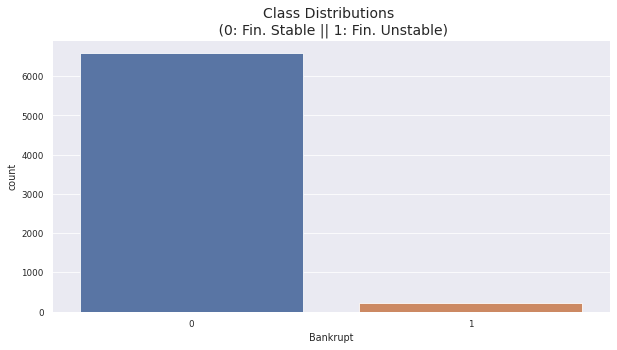

In [15]:
sns.set_theme(context = 'paper')
plt.figure(figsize = (10,5))
sns.countplot(df['Bankrupt'])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
plt.show()

Замечаем, что реальные данные плохо сбалансированны, что при решении задачи регрессии модель будет наивно предсказывать класс большинства

Вернемся к балансированию данны чуть позже, после обработки выбрасов

## 3. Удаление выбросов

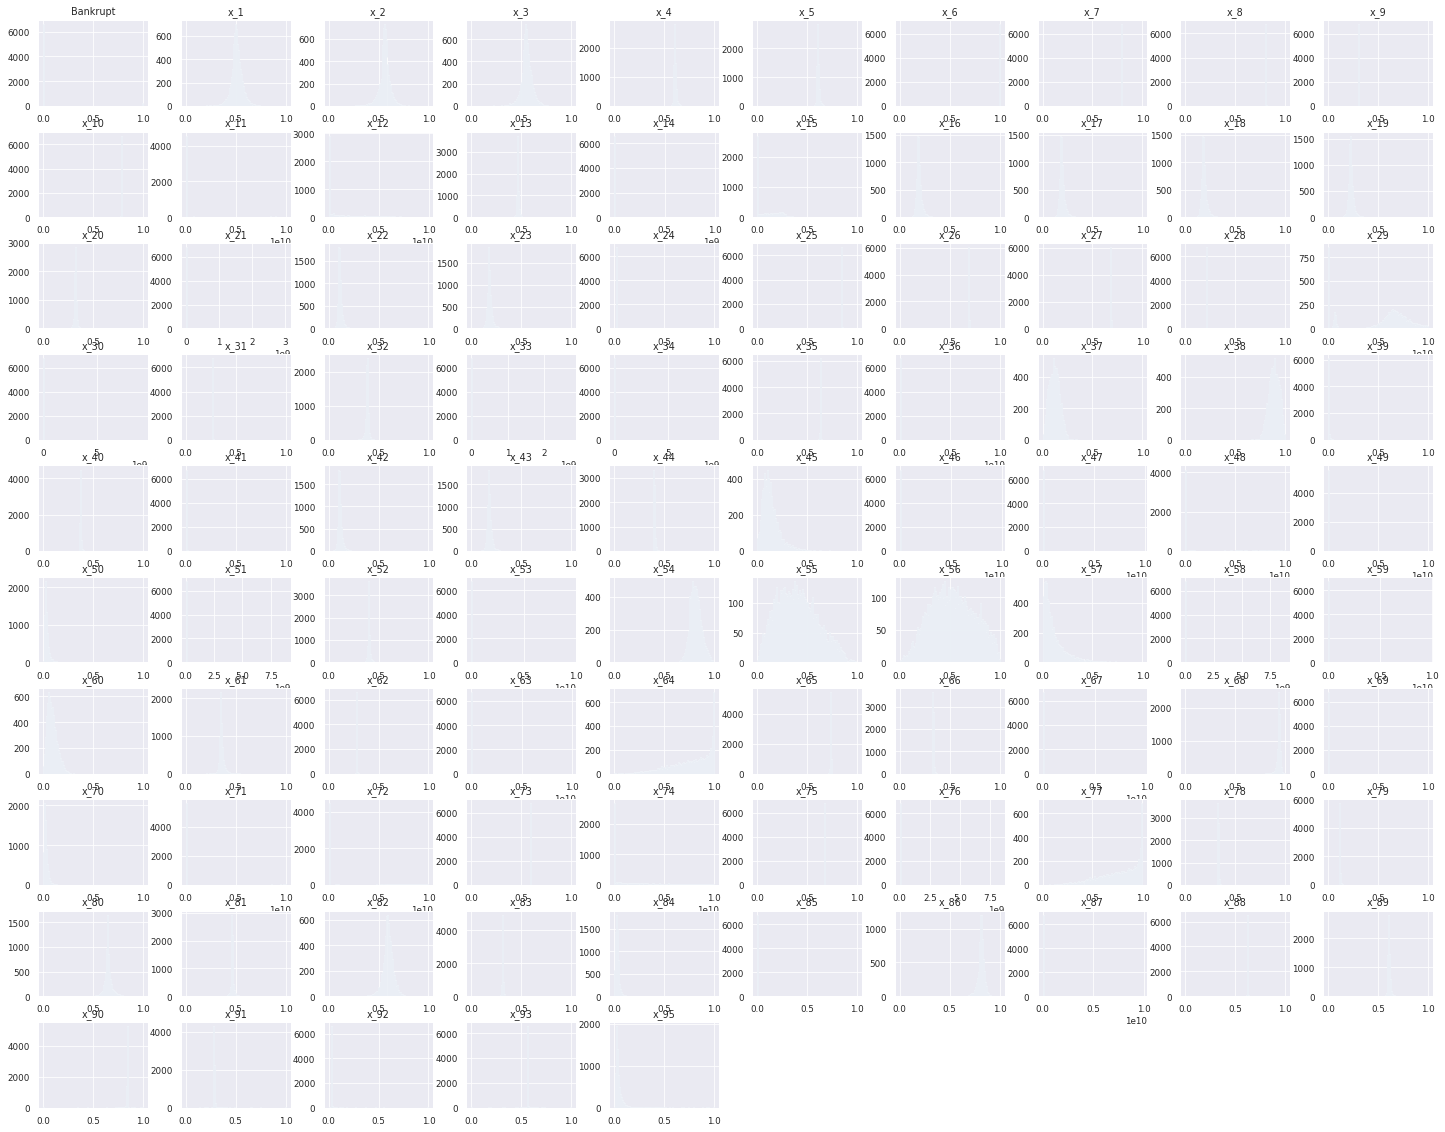

In [16]:
df.hist(figsize = (25,20), bins = 100)
plt.show() # Гистрограммы признаков

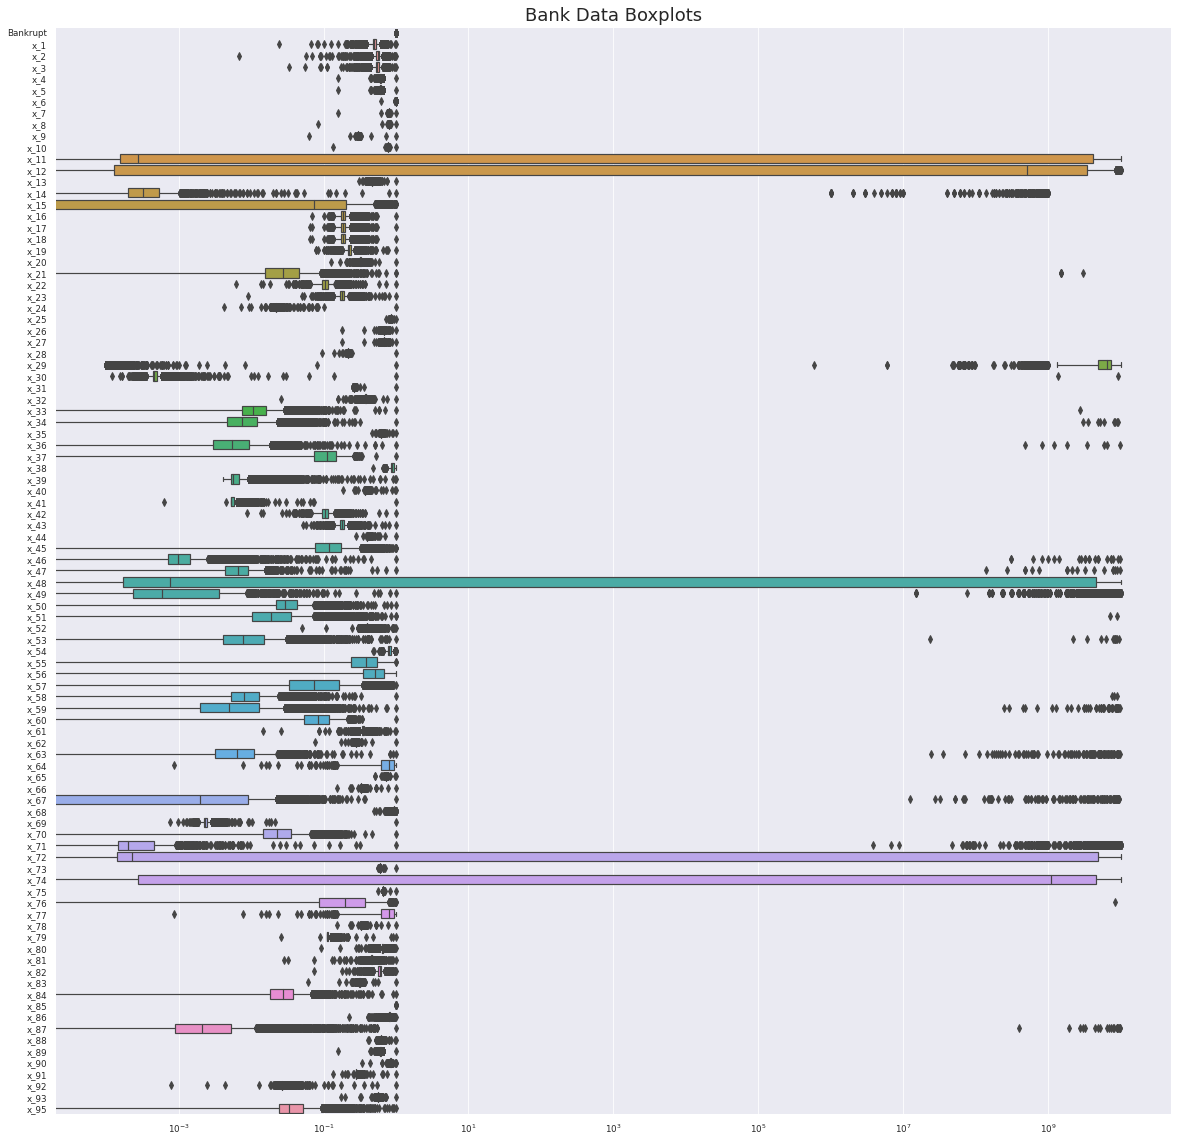

In [17]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show() # Ящики с усами (боксплоты)

Заметим, что большое количество признаков имеют отклонений (выбросов) - > удалим их

In [18]:
def outliers_removal(feature,feature_name,dataset):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    #print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    urange = q75 - q25
    #print('urange: {}'.format(urange))
    
    feat_cut_off = urange * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    #print(feature_name +' Lower: {}'.format(feat_lower))
    #print(feature_name +' Upper: {}'.format(feat_upper))

    df.loc[df[feature_name] > feat_upper, feature_name] = np.nan
    df.loc[df[feature_name] < feat_lower, feature_name] = np.nan
    #print('-' * 65)
    return dataset

In [19]:
for col in df.loc[:, df.columns != 'Bankrupt']:
    new_df = outliers_removal(df[col], str(col), df)

In [20]:
nulls_table(df) # процент отсутствующих значений

,column,nulls_%
92,x_92,22.041355
93,x_93,20.838833
49,x_49,20.794838
71,x_71,20.516205
29,x_29,20.252236
...,...,...
64,x_64,0.586596
38,x_38,0.439947
37,x_37,0.439947
85,x_85,0.117319


In [21]:
rows = df.shape[0]
columns = df.shape[1]

# удалим строки, в которых количество NaN элементов превышает 20% общего объема данных
df = df.dropna(thresh = round(columns*0.8, 0))
# удалим столбцы, в которых количество NaN элементов превышает 20% общего объема данных
df = df.dropna(axis = 1, thresh = round(rows*0.8, 0))

df.shape

(6287, 84)

In [22]:
nulls_table(df)

,column,nulls_%
27,x_28,13.233657
24,x_25,12.979163
25,x_26,12.899634
26,x_27,12.883728
68,x_75,12.613329
...,...,...
49,x_54,0.556704
55,x_60,0.524893
70,x_77,0.493081
58,x_64,0.493081


In [23]:
for i in df.columns:
    df[i] = df[i].fillna(df[i].mean()) # Замена числовых признаков на среднее

In [24]:
nulls_table(df)

,column,nulls_%


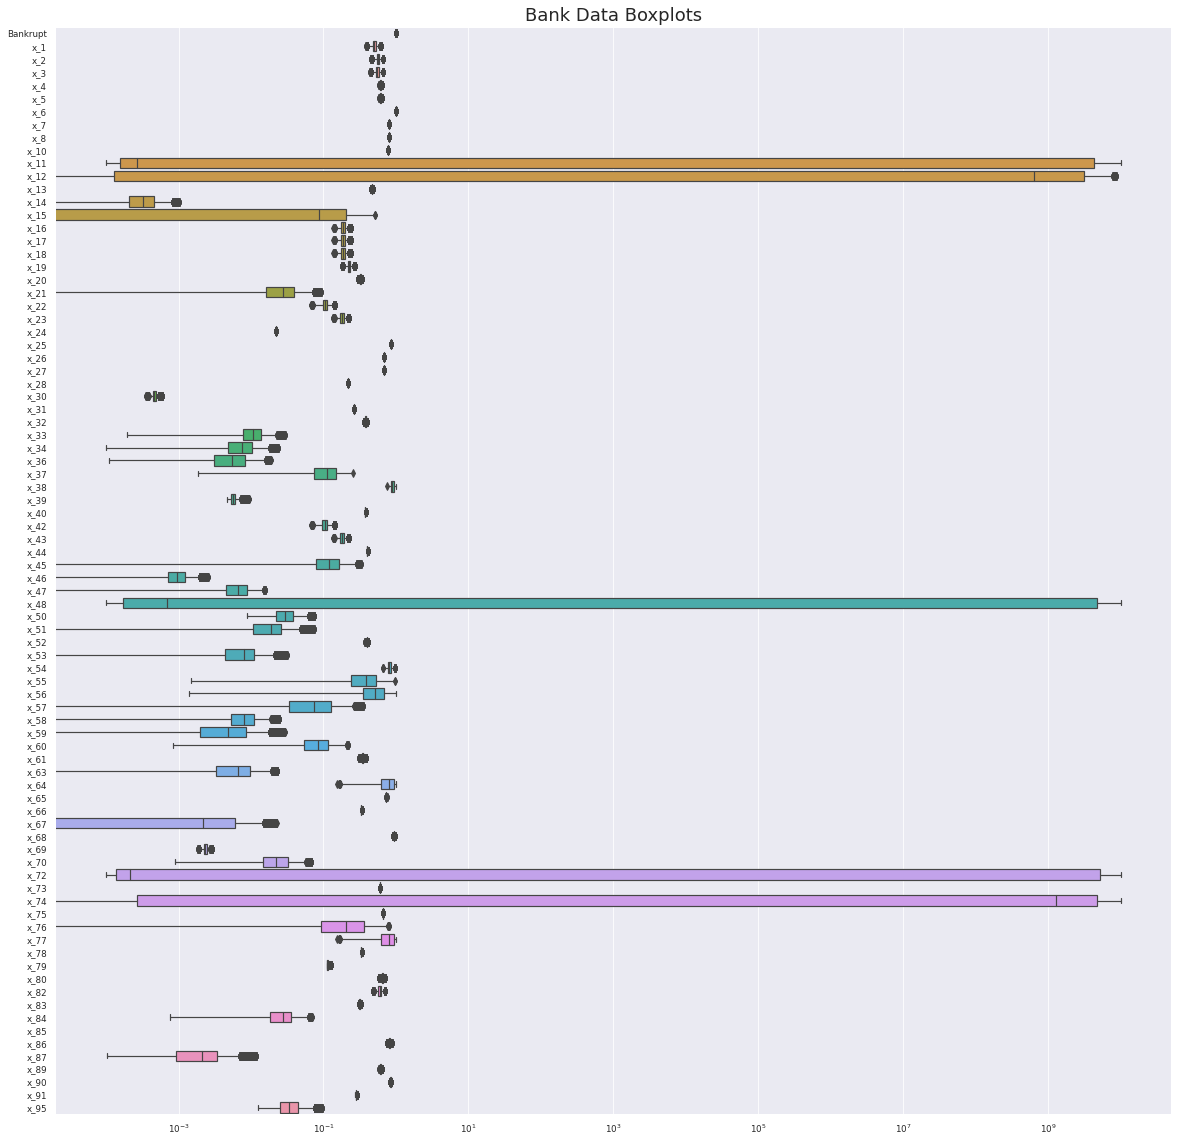

In [25]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show() # Ящики с усами (боксплоты)

In [26]:
# Снова проверим и удалим неинформативные признаки с помощью поиска уникальных значений (тк после удаления выбрасов и замены пропусков такие признаки могли появиться)
to_del = []
for col in df.columns:
  if len(df[col].unique()) == 1:
    to_del.append(col)

to_del

['x_85']

In [27]:
df = df.drop(to_del, axis = 1)

In [28]:
make_model(df, name = '-выбросы и пропуски')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.971408,0.512405,0.517133,0.570815,0.704497
1,-первичная обработка,0.968475,0.499244,0.491993,0.484949,0.731132
2,-выбросы и пропуски,0.974563,0.499593,0.493559,0.487669,0.229130


# Работа с признаками

## 4. Коррелирующие признаки

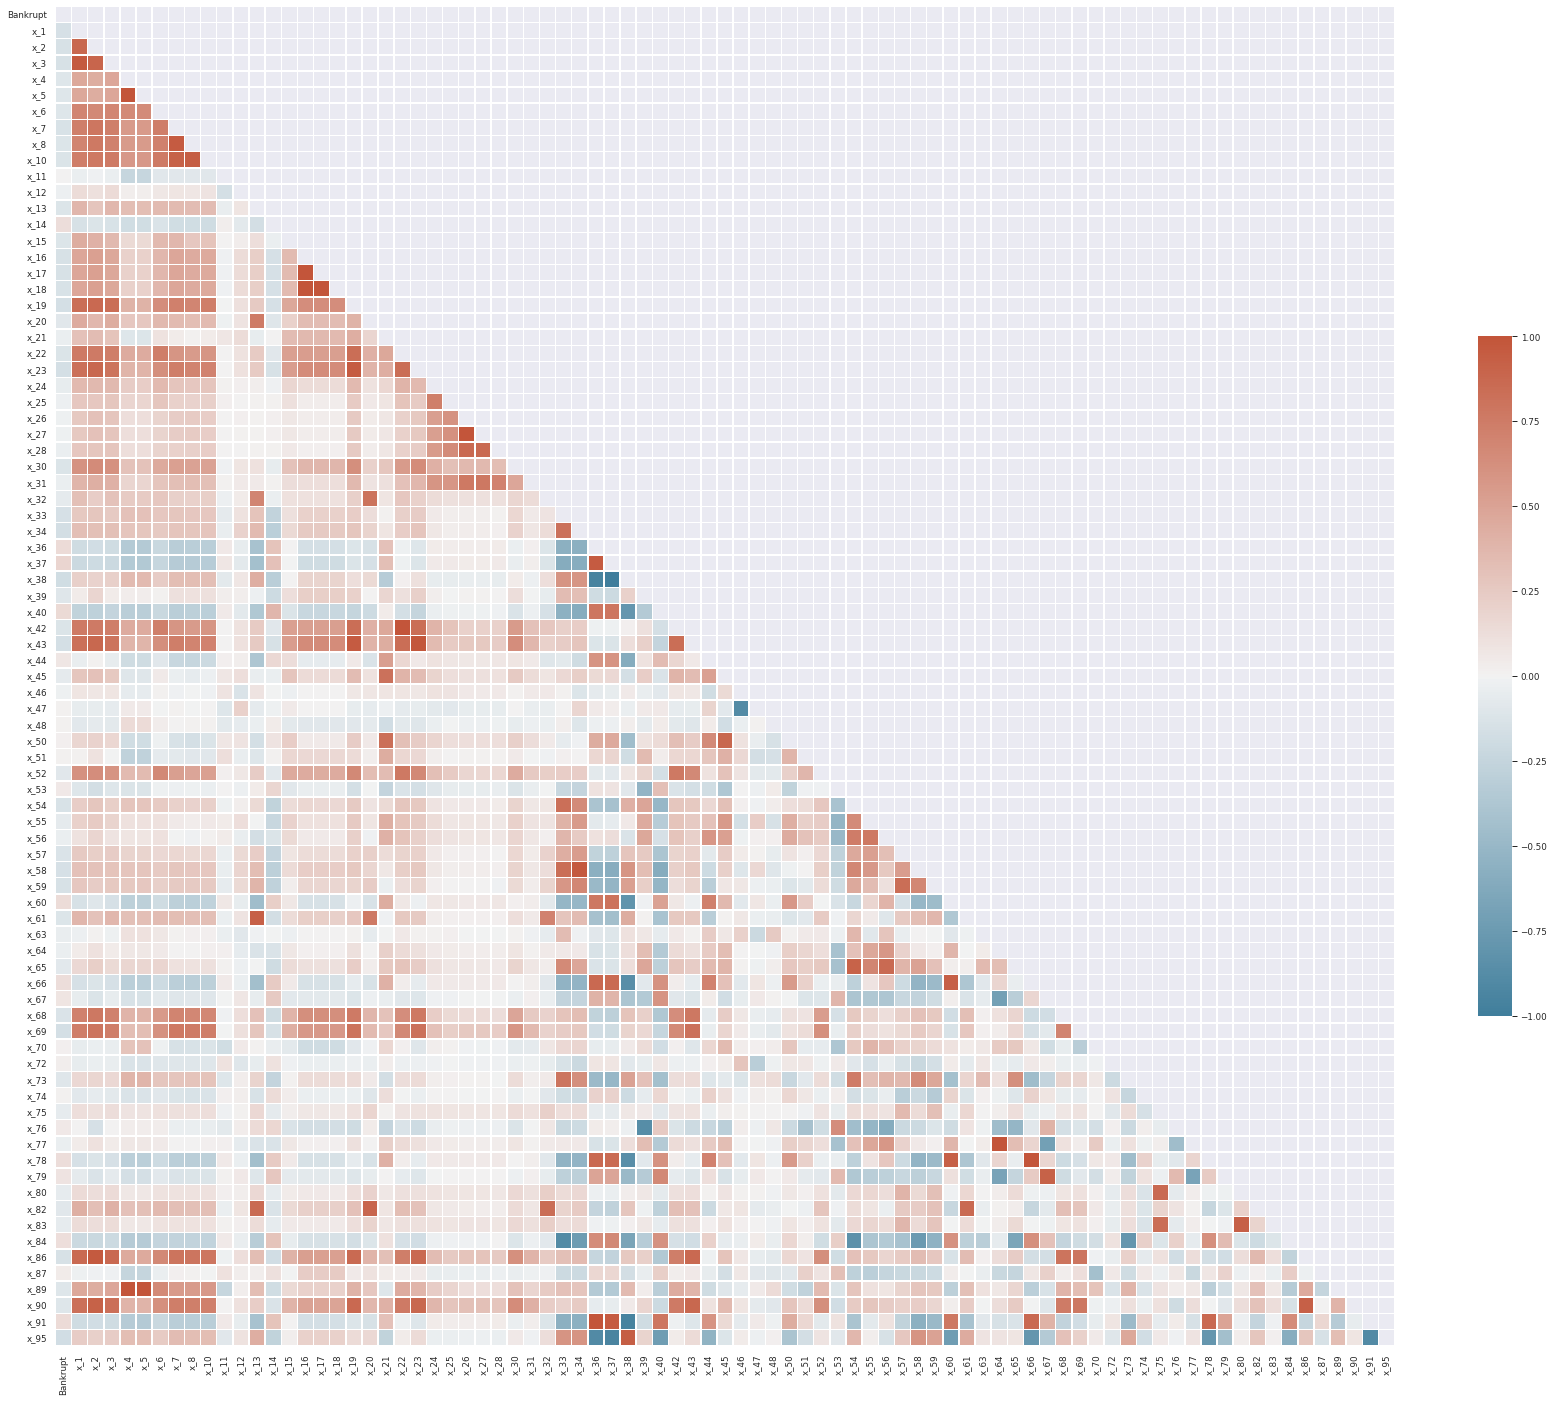

In [29]:
f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [30]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

<ipython-input-30-f5b1a5ec98f5>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [31]:
df.shape

(6287, 83)

In [32]:
len(to_drop)

29

In [33]:
# Удаляем коррелирующие признаки
df = df.drop(to_drop, axis = 1)
df.shape

(6287, 54)

In [34]:
make_model(df, name = '-коррелирующие признаки')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.971408,0.512405,0.517133,0.570815,0.704497
1,-первичная обработка,0.968475,0.499244,0.491993,0.484949,0.731132
2,-выбросы и пропуски,0.974563,0.499593,0.493559,0.487669,0.229130
3,-коррелирующие признаки,0.977742,0.500000,0.494373,0.488871,0.239320


## 5. PCA + стандартизация

In [36]:
dfff = df.copy()

In [37]:
X = dfff.drop(['Bankrupt'], axis = 1) # факторные переменные
y = dfff.Bankrupt

#scaling=StandardScaler()
#scaling.fit(X) 
#Scaled_data=scaling.transform(X)

# преобразуем данные к двум главным компонентам
pca = PCA(n_components=2)
#pca.fit(X)
X_pca = pca.fit_transform(X)
print("Форма исходного массива: {}".format(str(X.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_pca.shape)))
print("Форма: {}".format(str(y.shape)))

Форма исходного массива: (6287, 53)
Форма массива после сокращения размерности: (6287, 2)
Форма: (6287,)


In [38]:
X_pca = pd.DataFrame(X_pca)

In [39]:
X_pca['Bankrupt'] = pd.DataFrame(y)

In [40]:
X_pca.info() # gпочему появляются NaN в у???

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6287 entries, 0 to 6286
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         6287 non-null   float64
 1   1         6287 non-null   float64
 2   Bankrupt  5807 non-null   float64
dtypes: float64(3)
memory usage: 147.5 KB


In [44]:
pd.DataFrame(y).info() # так ведь нет Nan))) как это получается?)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6287 entries, 1 to 6817
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Bankrupt  6287 non-null   int64
dtypes: int64(1)
memory usage: 227.3 KB


In [45]:
pd.DataFrame(y).nunique()

Bankrupt    2
dtype: int64

In [80]:
№make_model(df, name = '-pca')

ValueError: ignored

## 6. Избавление от несбалансированности данных

По результатам проведения теста в конце поняла, что лучше не становится (и precision, и recall растут), поэтому предлагаю полностью исключить проверку на сбалансированность в работе, тк также эта проблема решается и использованием каких-то специальных методов непостредственно при построении модели (углубление в машинное обучение, другая тема курсовой работы)

In [45]:
print('Financially stable: ', round(df['Bankrupt'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Financially unstable: ', round(df['Bankrupt'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

Financially stable:  97.87 % of the dataset
Financially unstable:  2.13 % of the dataset


**Для баланса и точности предсказания модели принято использовать методы обогащения классов, например, создать синтетические образцы методом SMOTE («Техника передискретизации синтетического меньшинства»)**

Он работает, создавая синтетические образцы из младшего класса вместо создания копий. Алгоритм выбирает два или более одинаковых экземпляра (используя меру расстояния) и возмущает один атрибут экземпляра за раз на случайную величину в пределах разницы с соседними экземплярами.

In [46]:
from imblearn.over_sampling import SMOTE
X = df.drop(['Bankrupt'], axis = 1)
y = df.Bankrupt
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

df = pd.concat([y, X], axis=1)
print(f'{len(df[df.Bankrupt == 1])} случаев банкротсва к {len(df[df.Bankrupt == 0])} не банкротсва')

6153 случаев банкротсва к 6153 не банкротсва


In [47]:
make_model(df, name = '-дисбаланс данных')

,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.971408,0.512405,0.517133,0.570815,0.704497
1,-первичная обработка,0.968475,0.499244,0.491993,0.484949,0.731132
2,-выбросы и пропуски,0.974563,0.499593,0.493559,0.487669,0.229130
3,-коррелирующие признаки,0.977742,0.500000,0.494373,0.488871,0.239320
4,-дисбаланс данных,0.883022,0.885373,0.882966,0.887504,0.747160


# Итог

Видим, что в результате (игнорируя ступень "-дисбаланс данных-") наша модель улучшила показатели точности и теперь ее можно использовать для модели машинного обучения

In [41]:
df.tail()

,Bankrupt,x_1,x_4,x_6,x_7,x_11,x_12,x_13,x_14,x_15,...,x_70,x_72,x_73,x_74,x_75,x_76,x_79,x_80,x_84,x_87
12301,1,0.414735,0.607805,0.998818,0.797160,3.788256e-04,1.493720e-04,0.459324,0.000527,0.000000,...,0.034492,1.362259e-04,0.593937,3.040893e+08,0.671575,0.351968,0.113410,0.646798,0.037746,0.000762
12302,1,0.441679,0.593822,0.998975,0.797375,2.480283e-04,1.847081e+09,0.461784,0.000692,0.000000,...,0.023562,1.492701e-04,0.593966,4.471412e+08,0.671559,0.358556,0.111834,0.636502,0.032928,0.005134
12303,1,0.469211,0.590633,0.999038,0.797456,1.029949e+09,1.237982e-04,0.461684,0.000722,0.025814,...,0.016955,9.887511e+06,0.593964,2.475998e+07,0.671574,0.510609,0.115738,0.645240,0.041289,0.004494
12304,1,0.494795,0.600608,0.999022,0.797381,5.916930e+09,0.000000e+00,0.461170,0.000785,0.000000,...,0.014740,1.548517e-04,0.593896,1.274904e+09,0.671568,0.494890,0.113918,0.637845,0.056098,0.003500
12305,1,0.422736,0.588946,0.998800,0.797155,9.490395e+09,3.281325e+09,0.461679,0.000300,0.007358,...,0.019029,6.965286e+09,0.593876,6.272559e+09,0.671581,0.351487,0.119046,0.650264,0.066195,0.002749


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12306 entries, 0 to 12305
Data columns (total 54 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Bankrupt  12306 non-null  int64  
 1   x_1       12306 non-null  float64
 2   x_4       12306 non-null  float64
 3   x_6       12306 non-null  float64
 4   x_7       12306 non-null  float64
 5   x_11      12306 non-null  float64
 6   x_12      12306 non-null  float64
 7   x_13      12306 non-null  float64
 8   x_14      12306 non-null  float64
 9   x_15      12306 non-null  float64
 10  x_16      12306 non-null  float64
 11  x_19      12306 non-null  float64
 12  x_20      12306 non-null  float64
 13  x_21      12306 non-null  float64
 14  x_24      12306 non-null  float64
 15  x_25      12306 non-null  float64
 16  x_26      12306 non-null  float64
 17  x_30      12306 non-null  float64
 18  x_31      12306 non-null  float64
 19  x_32      12306 non-null  float64
 20  x_33      12306 non-null  fl

# Mетод взаимной классификации для определения наиболее значимых признаков
измеряет зависимость функций от целевого значения

In [361]:
X = df_normalized.drop(['Bankrupt'], axis = 1) # факторные переменные
y = df_normalized.Bankrupt

In [362]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize = (15,10))
importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, X.columns[0:len(df.columns)-1])
feature_importances.plot(kind='bar', color='teal')
plt.show()

<ipython-input-362-7c5499b9adf1>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (15,10))


In [363]:
feature_importances = pd.DataFrame({'column':feature_importances.index, 'imortance': feature_importances.values}).sort_values(by = 'imortance')
feature_importances.head()

,column,imortance
23,x_47,0.018007
38,x_70,0.036927
30,x_55,0.036966
11,x_24,0.037805
13,x_26,0.039238


In [310]:
# Удалим совсем незначимые признаки (важность = 0)
unimportant_features = list(feature_importances[feature_importances.imortance == 0].column)
unimportant_features

['x_46', 'x_76', 'x_72', 'x_11', 'x_56', 'x_31', 'x_21']

In [311]:
df = df.drop(unimportant_features, axis = 1)

In [312]:
df.shape

(6287, 47)

In [313]:
make_model(df, name = '-незначимые признаки')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,stage,accuracy_to_max,recall_to_max,F1_to_max,precision_to_min,time
0,Исходные данные,0.964809,0.499241,0.491045,0.483113,0.289464
1,-первичная обработка,0.964809,0.509879,0.511038,0.649767,0.288611
2,-выбросы и пропуски,0.975358,0.499593,0.493763,0.488067,0.322488
3,-коррелирующие признаки,0.975358,0.500000,0.493763,0.487679,0.260597
4,-незначимые признаки,0.980127,0.500000,0.494982,0.490064,0.224888
